In [ ]:
import pandas as pd

df = pd.read_csv('combined_bluebike_tripdata.csv')

df.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,399F3B5640FA95C7,classic_bike,2024-04-30 16:56:01,2024-04-30 19:12:48,Everett Square (Broadway at Norwood St),V32003,Chelsea St at Vine St,V32016,42.406721,-71.056438,42.403369,-71.047314,casual
1,2F8686F90772CC28,classic_bike,2024-04-15 17:27:02,2024-04-15 17:38:13,Nashua Street at Red Auerbach Way,A32025,Chinatown T Stop,D32019,42.365673,-71.064263,42.352409,-71.062679,casual
2,A6885D2B2CB78B9E,electric_bike,2024-04-01 18:07:03,2024-04-01 18:19:58,St Mary's,K32007,Chinatown T Stop,D32019,42.346226,-71.107078,42.352409,-71.062679,casual
3,1DC97B8EA498A8BA,electric_bike,2024-04-01 17:09:18,2024-04-01 17:15:54,Nashua Street at Red Auerbach Way,A32025,Chinatown T Stop,D32019,42.365749,-71.064280,42.352409,-71.062679,casual
4,704C39EED089A489,electric_bike,2024-04-12 21:35:23,2024-04-12 21:57:52,Nashua Street at Red Auerbach Way,A32025,Kennedy-Longfellow School 158 Spring St,M32065,42.365690,-71.064094,42.369553,-71.085790,casual


In [ ]:
from dateutil import parser

df['started_at'] = df['started_at'].astype(str).apply(lambda x: parser.parse(x) if pd.notnull(x) else pd.NaT)
df['ended_at'] = df['ended_at'].astype(str).apply(lambda x: parser.parse(x) if pd.notnull(x) else pd.NaT)


In [ ]:
missing_time = df['started_at'].isna() | df['ended_at'].isna()
print(f"⏳ Still missing timestamps after flexible parsing: {missing_time.sum():,}")


⏳ Still missing timestamps after flexible parsing: 0


In [ ]:
# Step 0 — Record initial count
initial_count = df.shape[0]

# Step 1 — Drop trips with missing station IDs
missing_station_ids = df['start_station_id'].isna() | df['end_station_id'].isna()
drop_missing_stations = missing_station_ids.sum()
df = df[~missing_station_ids]

# Step 2 — Clean + Convert timestamps safely
df['started_at'] = pd.to_datetime(df['started_at'].astype(str).str.strip(), errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'].astype(str).str.strip(), errors='coerce')

# converting strings to datetime after stripping whitespace, which prevents accidental NaT coercion due to stray characters above

# Drop rows where timestamp conversion failed
missing_time = df['started_at'].isna() | df['ended_at'].isna()
drop_missing_time = missing_time.sum()
df = df[~missing_time]

# Step 3 — Compute trip duration in minutes
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Step 4 — Drop trips with duration < 2 min or > 120 min
invalid_durations = (df['trip_duration_min'] < 2) | (df['trip_duration_min'] > 120)
drop_invalid_durations = invalid_durations.sum()
df = df[~invalid_durations]

# Step 5 — Drop loop trips (start == end station)
loop_trips = df['start_station_id'] == df['end_station_id']
drop_loop_trips = loop_trips.sum()
df = df[~loop_trips]

# Step 6 — Drop low-volume stations (<100 total trips)
station_counts = pd.concat([df['start_station_id'], df['end_station_id']]).value_counts()
low_volume_stations = station_counts[station_counts < 100].index
low_volume_filter = df['start_station_id'].isin(low_volume_stations) | df['end_station_id'].isin(low_volume_stations)
drop_low_volume = low_volume_filter.sum()
df_cleaned = df[~low_volume_filter]

# Final summary
print(f"Total initial trips: {initial_count:,}")
print(f"➝ Dropped for missing station IDs: {drop_missing_stations:,}")
print(f"➝ Dropped for missing timestamps: {drop_missing_time:,}")
print(f"➝ Dropped for invalid trip durations (<2 or >120 min): {drop_invalid_durations:,}")
print(f"➝ Dropped for loop trips (same start/end): {drop_loop_trips:,}")
print(f"➝ Dropped for low-volume stations (<100 total uses): {drop_low_volume:,}")
print(f"Final cleaned trip count: {df_cleaned.shape[0]:,}")


Total initial trips: 3,893,654
➝ Dropped for missing station IDs: 0
➝ Dropped for missing timestamps: 0
➝ Dropped for invalid trip durations (<2 or >120 min): 76,345
➝ Dropped for loop trips (same start/end): 115,771
➝ Dropped for low-volume stations (<100 total uses): 55
Final cleaned trip count: 3,701,483


In [ ]:
# Count how many times each station appears (start or end)
import pandas as pd
station_counts = pd.concat([
    df_cleaned['start_station_id'],
    df_cleaned['end_station_id']
]).value_counts()

# Identify stations with fewer than 10 total appearances
low_volume_stations = station_counts[station_counts < 100].index
print(f"Stations with <10 total trips: {len(low_volume_stations)}")

# Filter out trips with low-volume start or end stations
df_cleaned = df_cleaned[
    ~df_cleaned['start_station_id'].isin(low_volume_stations) &
    ~df_cleaned['end_station_id'].isin(low_volume_stations)
]

# Confirm filtering
print(f"Remaining trips after removing low-volume stations: {df_cleaned.shape[0]:,}")


Stations with <10 total trips: 0
Remaining trips after removing low-volume stations: 3,701,483


In [ ]:
# Strip extra whitespace and unify casing
df_cleaned['start_station_name'] = df_cleaned['start_station_name'].str.strip().str.title()
df_cleaned['end_station_name'] = df_cleaned['end_station_name'].str.strip().str.title()

# Normalize names for the same station_id
# Create a mapping from station_id to a consistent, canonical name
# Based on the most frequent name associated with each station_id

# Combine both start and end station names with their IDs
station_names = pd.concat([
    df_cleaned[['start_station_id', 'start_station_name']].rename(columns={
        'start_station_id': 'station_id',
        'start_station_name': 'station_name'
    }),
    df_cleaned[['end_station_id', 'end_station_name']].rename(columns={
        'end_station_id': 'station_id',
        'end_station_name': 'station_name'
    })
])

# Count frequency of names per station_id
canonical_names = (
    station_names
    .groupby(['station_id', 'station_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['station_id', 'count'], ascending=[True, False])
    .drop_duplicates(subset='station_id')
    .set_index('station_id')['station_name']
    .to_dict()
)

# Apply canonical names back to trips
df_cleaned['start_station_name'] = df_cleaned['start_station_id'].map(canonical_names)
df_cleaned['end_station_name'] = df_cleaned['end_station_id'].map(canonical_names)

# Preview
print("Sample of cleaned station names:")
print(df_cleaned[['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name']].sample(5))


Sample of cleaned station names:
        start_station_id                                 start_station_name  \
1204359           C32004                  Massachusetts Ave At Columbus Ave   
2458327           K32006                     Commonwealth Ave At Babcock St   
3803067           M32006                       Mit At Mass Ave / Amherst St   
3091372           M32052  Cambridge Dept. Of Public Works -147 Hampshire...   
1504270           C32037                   Four Corners - 157 Washington St   

        end_station_id                                   end_station_name  
1204359         D32004                             Arch St At Franklin St  
2458327         M32022  Lower Cambridgeport At Magazine St / Riverside Rd  
3803067         M32038  Harvard University River Houses At Dewolfe St ...  
3091372         D32016        Charles Circle - Charles St At Cambridge St  
1504270         C32002  Boston Medical Center - E Concord St At Harris...  


In [ ]:
# Extract temporal features from 'started_at' column
df_cleaned['hour'] = df_cleaned['started_at'].dt.hour
df_cleaned['day_of_week'] = df_cleaned['started_at'].dt.day_name()
df_cleaned['month'] = df_cleaned['started_at'].dt.month
df_cleaned['week'] = df_cleaned['started_at'].dt.isocalendar().week
df_cleaned['is_weekday'] = df_cleaned['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

# preview
print(df_cleaned[['started_at', 'hour', 'day_of_week', 'month', 'week', 'is_weekday']].sample(5))


                     started_at  hour day_of_week  month  week  is_weekday
708471  2024-05-16 14:06:06.000    14    Thursday      5    20        True
1633420 2024-07-28 12:28:23.486    12      Sunday      7    30       False
2328675 2024-08-29 07:27:57.589     7    Thursday      8    35        True
1959748 2024-08-05 17:35:57.687    17      Monday      8    32        True
1999537 2024-08-13 15:09:30.146    15     Tuesday      8    33        True


In [ ]:
print(f"Duplicate trips: {df_cleaned.duplicated().sum()}")
df_cleaned = df_cleaned.drop_duplicates()


Duplicate trips: 0


In [ ]:
# Show count of nulls in each important column
df_cleaned[['ride_id', 'started_at', 'ended_at',
            'start_station_id', 'end_station_id',
            'start_station_name', 'end_station_name',
            'trip_duration_min', 'member_casual']].isnull().sum()


,0
ride_id,0
started_at,0
ended_at,0
start_station_id,0
end_station_id,0
start_station_name,0
end_station_name,0
trip_duration_min,0
member_casual,0


In [ ]:
df_cleaned['trip_duration_min'].describe()


,trip_duration_min
count,3.701483e+06
mean,1.481323e+01
std,1.248377e+01
min,2.000000e+00
25%,6.983942e+00
50%,1.138333e+01
75%,1.843233e+01
max,1.199963e+02


In [ ]:
(df_cleaned['ended_at'] < df_cleaned['started_at']).sum()


np.int64(0)

In [ ]:
df_cleaned.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_min,hour,day_of_week,month,week,is_weekday,dayofweek
1,2F8686F90772CC28,classic_bike,2024-04-15 17:27:02,2024-04-15 17:38:13,Nashua Street At Red Auerbach Way,A32025,Chinatown T Stop,D32019,42.365673,-71.064263,42.352409,-71.062679,casual,11.183333,17,Monday,4,16,True,Monday
2,A6885D2B2CB78B9E,electric_bike,2024-04-01 18:07:03,2024-04-01 18:19:58,St Mary'S,K32007,Chinatown T Stop,D32019,42.346226,-71.107078,42.352409,-71.062679,casual,12.916667,18,Monday,4,14,True,Monday
3,1DC97B8EA498A8BA,electric_bike,2024-04-01 17:09:18,2024-04-01 17:15:54,Nashua Street At Red Auerbach Way,A32025,Chinatown T Stop,D32019,42.365749,-71.064280,42.352409,-71.062679,casual,6.600000,17,Monday,4,14,True,Monday
4,704C39EED089A489,electric_bike,2024-04-12 21:35:23,2024-04-12 21:57:52,Nashua Street At Red Auerbach Way,A32025,Kennedy-Longfellow School 158 Spring St,M32065,42.365690,-71.064094,42.369553,-71.085790,casual,22.483333,21,Friday,4,15,True,Friday
5,C07D2630DC8B185C,classic_bike,2024-04-17 09:42:29,2024-04-17 10:02:58,Sydney St At Carson St,C32064,Chinatown T Stop,D32019,42.320394,-71.053554,42.352409,-71.062679,member,20.483333,9,Wednesday,4,16,True,Wednesday


In [ ]:
df_cleaned.to_csv("cleaned_bluebiketrips.csv", index=False)

print("Cleaned dataset successfully exported to 'cleaned_bluebiketrips.csv'")


Cleaned dataset successfully exported to 'cleaned_bluebiketrips.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
import plotly.express as px

fig = px.histogram(
    df_cleaned,
    x='trip_duration_min',
    nbins=60,
    title='Distribution of Trip Durations (in Minutes)',
    labels={'trip_duration_min': 'Trip Duration (minutes)'},
    color_discrete_sequence=['#4C78A8']
)

fig.update_layout(
    title_x=0.5,  # centers the title
    bargap=0.1,
    plot_bgcolor='#f7f7f7',
    paper_bgcolor='white',
    font=dict(family='Arial', size=14, color='black'),
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14))
)
`
fig.show()



Output hidden; open in https://colab.research.google.com to view.

The histogram above illustrates the distribution of trip durations in minutes across all valid Bluebike rides. The majority of trips cluster between 5 and 20 minutes, with a sharp decline in frequency as duration increases, indicating that most users take short, utilitarian rides. The distribution is right-skewed, reflecting a long tail of less frequent, longer trips. This pattern suggests that bike-sharing usage is dominated by brief commutes or errands rather than extended travel.

In [ ]:
import plotly.express as px

df_cleaned['hour'] = df_cleaned['started_at'].dt.hour
hourly_duration = df_cleaned.groupby('hour')['trip_duration_min'].median().reset_index()

fig = px.line(hourly_duration,
              x='hour',
              y='trip_duration_min',
              title='Median Trip Duration by Hour of Day',
              markers=True,
              labels={'hour': 'Hour of Day', 'trip_duration_min': 'Median Duration (min)'})
fig.update_layout(title_x=0.5)
fig.show()


This line plot visualizes the median trip duration across each hour of the day, revealing subtle behavioral patterns in rider activity. Interestingly, trip durations peak around 1–2 AM, suggesting late-night or leisure rides tend to be longer, possibly due to reduced traffic, lack of MBTA access, and ride-share app prices increasing. From midday to early evening, the median duration gradually increases again, reflecting a blend of work-related and casual rides.

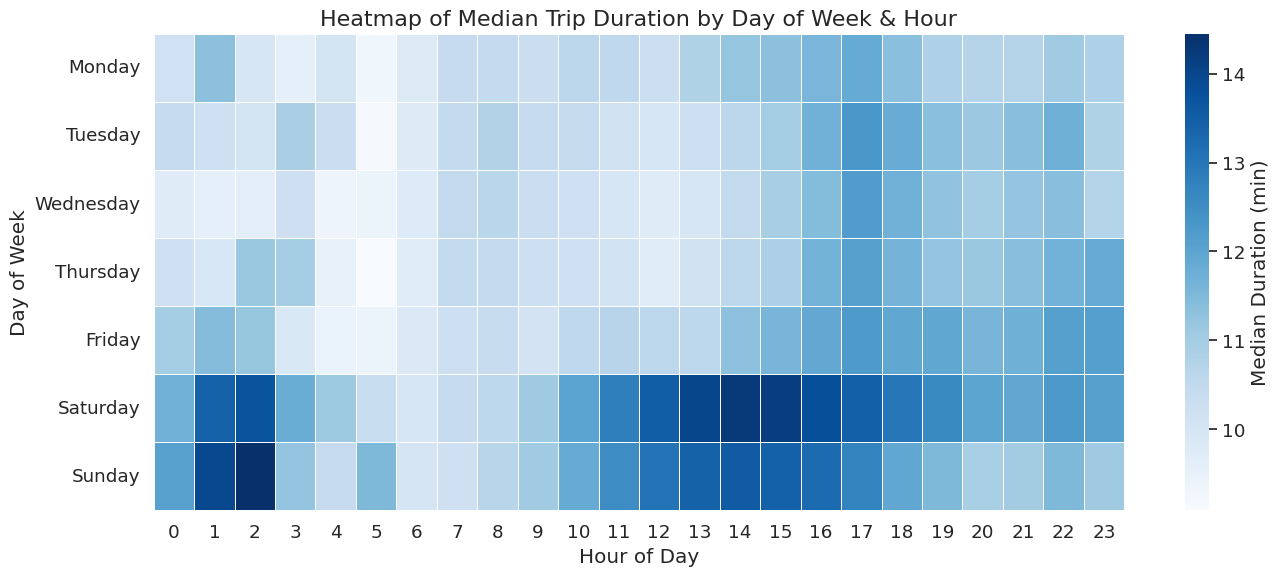

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cleaned['dayofweek'] = df_cleaned['started_at'].dt.day_name()
df_cleaned['hour'] = df_cleaned['started_at'].dt.hour

pivot_table = df_cleaned.pivot_table(values='trip_duration_min',
                                      index='dayofweek',
                                      columns='hour',
                                      aggfunc='median')

# Ensure proper order of days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap="Blues", linewidths=.5, cbar_kws={'label': 'Median Duration (min)'})
plt.title("🗓️ Heatmap of Median Trip Duration by Day of Week & Hour", fontsize=16, loc='center')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go


fig = go.Figure()

# Add grouped bars
fig.add_trace(go.Bar(
    x=top_n['station_name'],
    y=top_n['start_count'],
    name='Start Count',
    marker_color='rgb(102, 0, 204)',
    hovertemplate='Start Trips: %{y}<extra></extra>'
))

fig.add_trace(go.Bar(
    x=top_n['station_name'],
    y=top_n['end_count'],
    name='End Count',
    marker_color='rgb(0, 153, 153)',
    hovertemplate='End Trips: %{y}<extra></extra>'
))

# Modern layout
fig.update_layout(
    title={
        'text': 'Top 10 Most Active BlueBike Stations',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=22, family='Helvetica', color='black')
    },
    xaxis=dict(
        title='Station Name',
        tickangle=-30,
        tickfont=dict(size=11),
        automargin=True
    ),
    yaxis=dict(
        title='Trip Count',
        tickfont=dict(size=12),
        gridcolor='rgba(240,240,240,0.5)'
    ),
    barmode='group',
    bargap=0.25,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    plot_bgcolor='white',
    height=500
)

fig.show()


M32006


In [ ]:
import pandas as pd
import plotly.express as px

# Compute top 5 most frequent bike travel paths
top_routes = (
    df_cleaned.groupby(['start_station_name', 'end_station_name'])
    .size()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count', ascending=False)
    .head(5)
)

# Create a label for display: "Start → End"
top_routes['route'] = top_routes['start_station_name'] + " → " + top_routes['end_station_name']

# Plot horizontal bar chart
fig = px.bar(
    top_routes.sort_values(by='trip_count'),
    x='trip_count',
    y='route',
    orientation='h',
    color='trip_count',
    color_continuous_scale='Blues',
    title='Top 5 Most Frequent Bike Travel Routes (Start → End)',
    labels={'trip_count': 'Trip Count', 'route': 'Route'}
)

fig.update_layout(
    title_x=0.5,
    xaxis_title='Trip Count',
    yaxis_title='',
    height=400,
    margin=dict(l=100, r=40, t=50, b=40)
)

fig.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each unique route
route_counts = (
    df_cleaned.groupby(['start_station_name', 'end_station_name'])
    .size()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count', ascending=False)
)

# Basic stats
total_routes = route_counts.shape[0]
one_time_routes = (route_counts['trip_count'] == 1).sum()
over_100_routes = (route_counts['trip_count'] > 100).sum()

print(f"Total unique routes: {total_routes:,}")
print(f"Routes used only once: {one_time_routes:,} ({one_time_routes/total_routes:.2%})")
print(f"Routes used more than 100 times: {over_100_routes:,} ({over_100_routes/total_routes:.2%})")



Total unique routes: 124,525
Routes used only once: 23,936 (19.22%)
Routes used more than 100 times: 8,777 (7.05%)


In [ ]:
import pandas as pd
import plotly.express as px

# Step 1: Extract hour from 'started_at'
df_cleaned['start_hour'] = df_cleaned['started_at'].dt.hour

# Step 2: Identify top 6 most-used **start stations**
top_start_stations = df_cleaned['start_station_name'].value_counts().head(6).index

# Step 3: Filter for only those stations
df_top_stations = df_cleaned[df_cleaned['start_station_name'].isin(top_start_stations)]

# Step 4: Group by hour and station
hourly_station_counts = (
    df_top_stations
    .groupby(['start_station_name', 'start_hour'])
    .size()
    .reset_index(name='trip_count')
)

# Step 5: Faceted line plot
fig = px.line(
    hourly_station_counts,
    x='start_hour',
    y='trip_count',
    color='start_station_name',
    facet_col='start_station_name',
    facet_col_wrap=3,
    title='Hourly Trip Start Patterns for Top 6 Start Stations',
    labels={'start_hour': 'Hour of Day', 'trip_count': 'Trip Count'},
    height=500,
)

fig.update_layout(title_x=0.5, showlegend=False)
fig.update_xaxes(dtick=2)

fig.show()
